# Dog Breed Classification using CNN

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools

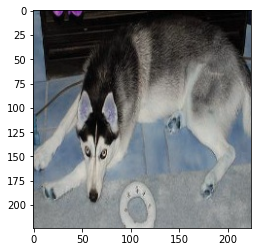

In [2]:
siberianhusky = cv2.imread('../../input/dataset-gerry-70-dog-breeds/train/Siberian Husky/01.jpg')
siberianhusky.shape
plt.imshow(siberianhusky)

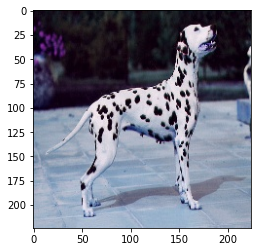

In [4]:
dalmation = cv2.imread('../../input/dataset-gerry-70-dog-breeds/train/Dalmation/01.jpg')
dalmation.shape
plt.imshow(dalmation)

In [5]:
class_folder_paths = ['../../input/dataset-gerry-70-dog-breeds/test/'+x for x in os.listdir('../../input/dataset-gerry-70-dog-breeds/test/')]
class_folder_paths

['../../input/dataset-gerry-70-dog-breeds/test/Afghan',
 '../../input/dataset-gerry-70-dog-breeds/test/African Wild Dog',
 '../../input/dataset-gerry-70-dog-breeds/test/Airedale',
 '../../input/dataset-gerry-70-dog-breeds/test/American Hairless',
 '../../input/dataset-gerry-70-dog-breeds/test/American Spaniel',
 '../../input/dataset-gerry-70-dog-breeds/test/Basenji',
 '../../input/dataset-gerry-70-dog-breeds/test/Basset',
 '../../input/dataset-gerry-70-dog-breeds/test/Beagle',
 '../../input/dataset-gerry-70-dog-breeds/test/Bearded Collie',
 '../../input/dataset-gerry-70-dog-breeds/test/Bermaise',
 '../../input/dataset-gerry-70-dog-breeds/test/Bichon Frise',
 '../../input/dataset-gerry-70-dog-breeds/test/Blenheim',
 '../../input/dataset-gerry-70-dog-breeds/test/Bloodhound',
 '../../input/dataset-gerry-70-dog-breeds/test/Bluetick',
 '../../input/dataset-gerry-70-dog-breeds/test/Border Collie',
 '../../input/dataset-gerry-70-dog-breeds/test/Borzoi',
 '../../input/dataset-gerry-70-dog-bree

#### check the number of images per class

In [6]:
for class_folder_path in class_folder_paths:
    print('{0}:'.format(class_folder_path), ' ', len(os.listdir(class_folder_path)))

../../input/dataset-gerry-70-dog-breeds/test/Afghan:   10
../../input/dataset-gerry-70-dog-breeds/test/African Wild Dog:   10
../../input/dataset-gerry-70-dog-breeds/test/Airedale:   10
../../input/dataset-gerry-70-dog-breeds/test/American Hairless:   10
../../input/dataset-gerry-70-dog-breeds/test/American Spaniel:   10
../../input/dataset-gerry-70-dog-breeds/test/Basenji:   10
../../input/dataset-gerry-70-dog-breeds/test/Basset:   10
../../input/dataset-gerry-70-dog-breeds/test/Beagle:   10
../../input/dataset-gerry-70-dog-breeds/test/Bearded Collie:   10
../../input/dataset-gerry-70-dog-breeds/test/Bermaise:   10
../../input/dataset-gerry-70-dog-breeds/test/Bichon Frise:   10
../../input/dataset-gerry-70-dog-breeds/test/Blenheim:   10
../../input/dataset-gerry-70-dog-breeds/test/Bloodhound:   10
../../input/dataset-gerry-70-dog-breeds/test/Bluetick:   10
../../input/dataset-gerry-70-dog-breeds/test/Border Collie:   10
../../input/dataset-gerry-70-dog-breeds/test/Borzoi:   10
../../i

## Model Building

In [7]:
train_path = '../../input/dataset-gerry-70-dog-breeds/train'
valid_path = '../../input/dataset-gerry-70-dog-breeds/valid'
test_path = '../../input/dataset-gerry-70-dog-breeds/test'

train_batch_size = 10
val_batch_size = 10
image_size = 224

### Data Preprocessing

In [8]:
datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [9]:
num_train_samples = 7946
num_val_samples = 700

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

### modify mobilenet model

In [10]:
# create a copy of a mobilenet model

mobile = tf.keras.applications.mobilenet.MobileNet()

In [11]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [12]:
type(mobile.layers)

list

In [13]:
# How many layers does MobileNet have?
len(mobile.layers)

93

In [14]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 70 corresponds to the number of classes (units)
x = Dropout(0.25)(x) # 0.25 = rate
predictions = Dense(70, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the dense layer created above.
model = Model(inputs=mobile.input, outputs=predictions)

In [15]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [16]:
# choose how many layers that's actually want to be trained.

# Here we are freezing the weights of all layers except the last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

### Training the model

In [17]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [18]:
model.compile(Adam(lr=0.01), loss='mse', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [19]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'Afghan': 0, 'African Wild Dog': 1, 'Airedale': 2, 'American Hairless': 3, 'American Spaniel': 4, 'Basenji': 5, 'Basset': 6, 'Beagle': 7, 'Bearded Collie': 8, 'Bermaise': 9, 'Bichon Frise': 10, 'Blenheim': 11, 'Bloodhound': 12, 'Bluetick': 13, 'Border Collie': 14, 'Borzoi': 15, 'Boston Terrier': 16, 'Boxer': 17, 'Bull Mastiff': 18, 'Bull Terrier': 19, 'Bulldog': 20, 'Cairn': 21, 'Chihuahua': 22, 'Chinese Crested': 23, 'Chow': 24, 'Clumber': 25, 'Cockapoo': 26, 'Cocker': 27, 'Collie': 28, 'Corgi': 29, 'Coyote': 30, 'Dalmation': 31, 'Dhole': 32, 'Dingo': 33, 'Doberman': 34, 'Elk Hound': 35, 'French Bulldog': 36, 'German Sheperd': 37, 'Golden Retriever': 38, 'Great Dane': 39, 'Great Perenees': 40, 'Greyhound': 41, 'Groenendael': 42, 'Irish Spaniel': 43, 'Irish Wolfhound': 44, 'Japanese Spaniel': 45, 'Komondor': 46, 'Labradoodle': 47, 'Labrador': 48, 'Lhasa': 49, 'Malinois': 50, 'Maltese': 51, 'Mex Hairless': 52, 'Newfoundland': 53, 'Pekinese': 54, 'Pit Bull': 55, 'Pomeranian': 56, 'Poodl

In [20]:
filepath = "model_mse_5.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=10, verbose=1,
                              callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
795/795 [==============================] - ETA: 0s - loss: 0.0154 - categorical_accuracy: 0.0571 - top_2_accuracy: 0.0948 - top_3_accuracy: 0.1304
Epoch 00001: val_top_3_accuracy improved from -inf to 0.12429, saving model to model_mse_5.h5
795/795 [==============================] - 286s 359ms/step - loss: 0.0154 - categorical_accuracy: 0.0571 - top_2_accuracy: 0.0948 - top_3_accuracy: 0.1304 - val_loss: 0.0164 - val_categorical_accuracy: 0.0471 - val_top_2_accuracy: 0.0857 - val_top_3_accuracy: 0.1243
Epoch 2/10
795/795 [==============================] - ETA: 0s - loss: 0.0133 - categorical_accuracy: 0.1732 - top_2_accuracy: 0.2596 - top_3_accuracy: 0.3236
Epoch 00002: val_top_3_accuracy improved from 0.12429 to 0.17286, saving model to model_mse_5.h5
795/795 [==============================] - 296s 372ms/step - loss: 0.0133 - categorical_accuracy: 0.1732 - top_2_accuracy: 0.2596 - top_3_accuracy: 0.

### Evaluate the model using the val set

In [21]:
# get the metric names so we can use evaluate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [38]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

700/700 [==============================] - 19s 27ms/step - loss: 0.0026 - categorical_accuracy: 0.8800 - top_2_accuracy: 0.9571 - top_3_accuracy: 0.9843
val_loss: 0.0025798690039664507
val_cat_acc: 0.8799999952316284
val_top_2_acc: 0.9571428298950195
val_top_3_acc: 0.9842857122421265


In [39]:
# Here the best epoch will be used.

model.load_weights('model_mse_5.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=700)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.0025798690039664507
val_cat_acc: 0.8799999952316284
val_top_2_acc: 0.9571428298950195
val_top_3_acc: 0.9842857122421265


### Plot the Training Curves

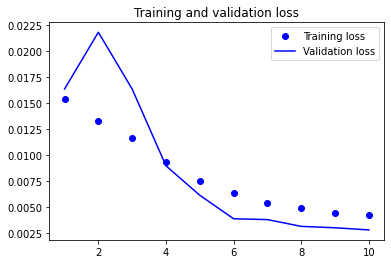

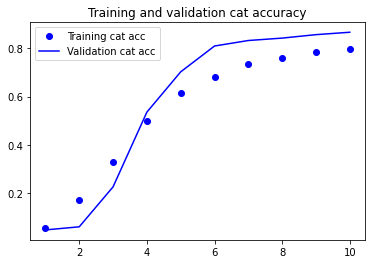

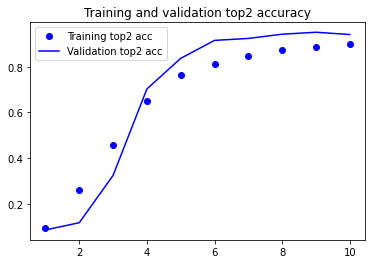

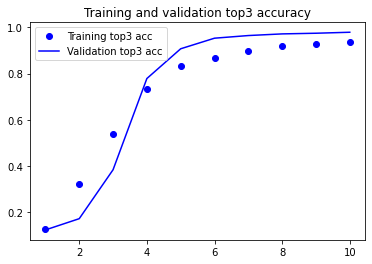

In [40]:
# display the loss and accuracy curves

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [41]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [42]:
# We need these to plot the confusion matrix.
test_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [43]:
# Print the label associated with each class
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

In [44]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=700, verbose=1)

700/700 [==============================] - 20s 28ms/step


In [45]:
predictions.shape

(700, 70)

In [46]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [47]:
test_labels.shape

(700,)

In [48]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [49]:
test_batches.class_indices

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

Confusion matrix, without normalization
[[10  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  8  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0  7]]


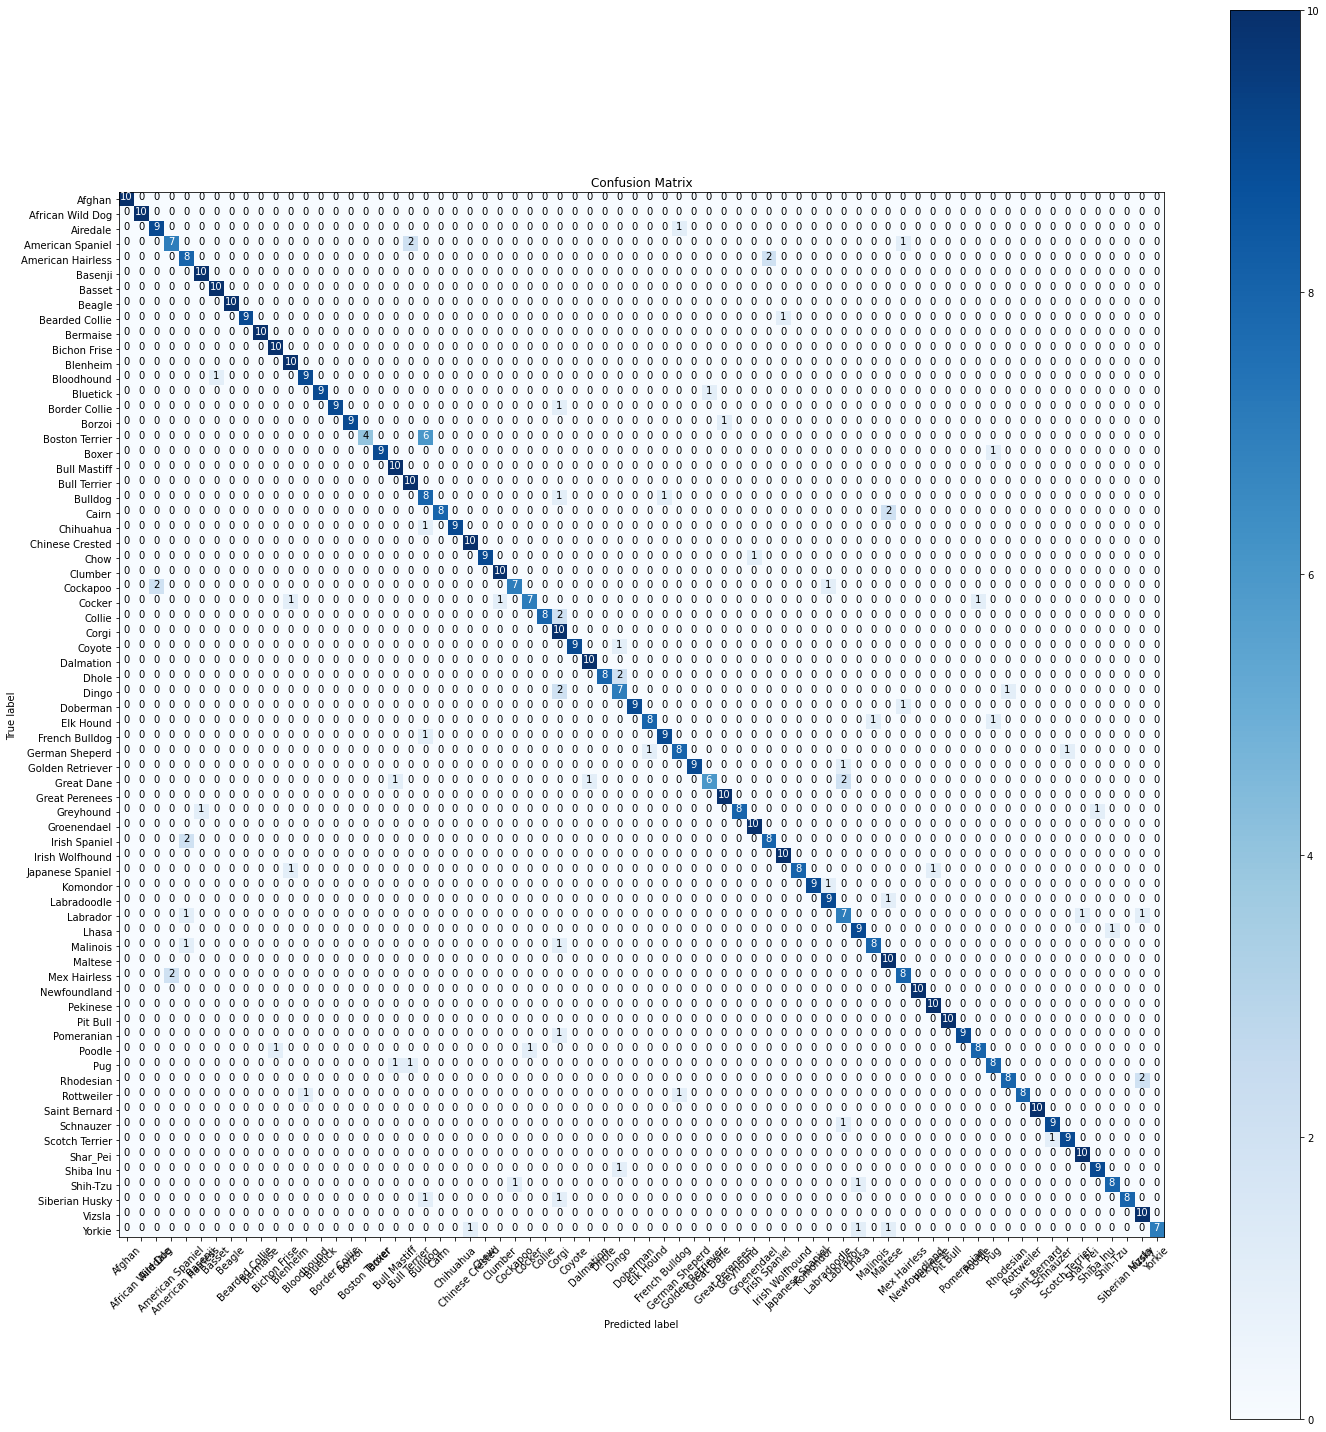

In [50]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['Afghan','African Wild Dog','Airedale','American Spaniel','American Hairless','Basenji','Basset','Beagle','Bearded Collie','Bermaise','Bichon Frise','Blenheim','Bloodhound','Bluetick','Border Collie','Borzoi','Boston Terrier','Boxer','Bull Mastiff','Bull Terrier','Bulldog','Cairn','Chihuahua','Chinese Crested','Chow','Clumber','Cockapoo','Cocker','Collie','Corgi','Coyote','Dalmation','Dhole','Dingo','Doberman','Elk Hound','French Bulldog','German Sheperd','Golden Retriever','Great Dane','Great Perenees','Greyhound','Groenendael','Irish Spaniel','Irish Wolfhound','Japanese Spaniel','Komondor','Labradoodle','Labrador','Lhasa','Malinois','Maltese','Mex Hairless','Newfoundland','Pekinese','Pit Bull','Pomeranian','Poodle','Pug','Rhodesian','Rottweiler','Saint Bernard','Schnauzer','Scotch Terrier','Shar_Pei','Shiba Inu','Shih-Tzu','Siberian Husky','Vizsla','Yorkie']
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [51]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [52]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

                   precision    recall  f1-score   support

           Afghan       1.00      1.00      1.00        10
 African Wild Dog       1.00      1.00      1.00        10
         Airedale       0.82      0.90      0.86        10
 American Spaniel       0.78      0.70      0.74        10
American Hairless       0.67      0.80      0.73        10
          Basenji       0.91      1.00      0.95        10
           Basset       0.91      1.00      0.95        10
           Beagle       1.00      1.00      1.00        10
   Bearded Collie       1.00      0.90      0.95        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       0.91      1.00      0.95        10
         Blenheim       0.83      1.00      0.91        10
       Bloodhound       0.90      0.90      0.90        10
         Bluetick       1.00      0.90      0.95        10
    Border Collie       1.00      0.90      0.95        10
           Borzoi       1.00      0.90      0.95       

<b>Recall</b> = Given a class, will the classifier be able to detect it?<br>
<b>Precision</b> = Given a class prediction from a classifier, how likely is it to be correct?<br>
<b>F1 Score</b> = The harmonic mean of the recall and precision. Essentially, it punishes extreme values